### 專案名稱: 第四屆機器學習百日馬拉松
### 功能描述: 第87天作業
### 版權所有: Dunk  
### 程式撰寫: Dunk  
### 撰寫日期：2020/06/19
### 改版日期:  
### 改版備註:

## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

### ANS:

In [9]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [10]:
train, test = keras.datasets.cifar10.load_data()

In [11]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [12]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [13]:
from keras.layers import BatchNormalization
"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [14]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [15]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""
建立實驗的比較組合
"""
# ValueError: ReduceLROnPlateau does not support a factor >= 1.0.
reduce_lr_factor = [0.2,0.5,0.8]
redice_lr_patient = [3,5,10]

In [16]:
import itertools
from keras.callbacks import ReduceLROnPlateau
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1) 
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.20, reduce_patient: 3
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_22 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_23 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
b

50000/50000 [==============================] - 8s 151us/step - loss: 1.6207 - accuracy: 0.4321 - val_loss: 1.6783 - val_accuracy: 0.4076
Epoch 11/25
50000/50000 [==============================] - 7s 147us/step - loss: 1.5997 - accuracy: 0.4408 - val_loss: 1.6691 - val_accuracy: 0.4106
Epoch 12/25
50000/50000 [==============================] - 8s 153us/step - loss: 1.5804 - accuracy: 0.4478 - val_loss: 1.6570 - val_accuracy: 0.4174
Epoch 13/25
50000/50000 [==============================] - 8s 155us/step - loss: 1.5624 - accuracy: 0.4528 - val_loss: 1.6470 - val_accuracy: 0.4188
Epoch 14/25
50000/50000 [==============================] - 8s 157us/step - loss: 1.5465 - accuracy: 0.4590 - val_loss: 1.6387 - val_accuracy: 0.4239
Epoch 15/25
50000/50000 [==============================] - 7s 149us/step - loss: 1.5305 - accuracy: 0.4655 - val_loss: 1.6317 - val_accuracy: 0.4262
Epoch 16/25
50000/50000 [==============================] - 7s 149us/step - loss: 1.5171 - accuracy: 0.4692 - val_loss:

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 186us/step - loss: 2.6095 - accuracy: 0.1763 - val_loss: 2.2098 - val_accuracy: 0.2005
Epoch 2/25
50000/50000 [==============================] - 8s 166us/step - loss: 2.1049 - accuracy: 0.2915 - val_loss: 2.1006 - val_accuracy: 0.2442
Epoch 3/25
50000/50000 [==============================] - 8s 165us/step - loss: 1.9397 - accuracy: 0.3360 - val_loss: 2.0008 - val_accuracy: 0.2863
Epoch 4/25
50000/50000 [==============================] - 8s 159us/step - loss: 1.8518 - accuracy: 0.3613 - val_loss: 1.9033 - val_accuracy: 0.3227
Epoch 5/25
50000/50000 [==============================] - 8s 158us/step - loss: 1.7924 - accuracy: 0.3821 - val_loss: 1.8415 - val_accuracy: 0.3464
Epoch 6/25
50000/50000 [==============================] - 8s 168us/step - loss: 1.7478 - accuracy: 0.3953 - val_loss: 1.7762 - val_accuracy: 0.3729
Epoch 7/25
50000/50000 [==============================] - 9s 1

50000/50000 [==============================] - 9s 181us/step - loss: 1.4673 - accuracy: 0.4865 - val_loss: 1.5983 - val_accuracy: 0.4421
Epoch 21/25
50000/50000 [==============================] - 8s 169us/step - loss: 1.4560 - accuracy: 0.4897 - val_loss: 1.5954 - val_accuracy: 0.4432
Epoch 22/25
50000/50000 [==============================] - 9s 182us/step - loss: 1.4460 - accuracy: 0.4939 - val_loss: 1.5829 - val_accuracy: 0.4488
Epoch 23/25
50000/50000 [==============================] - 9s 185us/step - loss: 1.4354 - accuracy: 0.4981 - val_loss: 1.5824 - val_accuracy: 0.4504
Epoch 24/25
50000/50000 [==============================] - 9s 172us/step - loss: 1.4261 - accuracy: 0.5006 - val_loss: 1.5738 - val_accuracy: 0.4526
Epoch 25/25
50000/50000 [==============================] - 8s 169us/step - loss: 1.4153 - accuracy: 0.5052 - val_loss: 1.5697 - val_accuracy: 0.4533
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 10
Model: "model_13"
_________________________________________

Epoch 5/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.7957 - accuracy: 0.3745 - val_loss: 1.8377 - val_accuracy: 0.3483
Epoch 6/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.7512 - accuracy: 0.3889 - val_loss: 1.7840 - val_accuracy: 0.3674
Epoch 7/25
50000/50000 [==============================] - 6s 112us/step - loss: 1.7146 - accuracy: 0.4007 - val_loss: 1.7524 - val_accuracy: 0.3771
Epoch 8/25
50000/50000 [==============================] - 6s 113us/step - loss: 1.6835 - accuracy: 0.4110 - val_loss: 1.7272 - val_accuracy: 0.3865
Epoch 9/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.6572 - accuracy: 0.4207 - val_loss: 1.7045 - val_accuracy: 0.3967
Epoch 10/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.6332 - accuracy: 0.4292 - val_loss: 1.6920 - val_accuracy: 0.4028
Epoch 11/25
50000/50000 [==============================] - 6s 112us/step - loss: 1.6120 - accuracy: 0.4364 - va

50000/50000 [==============================] - 9s 187us/step - loss: 1.4267 - accuracy: 0.5020 - val_loss: 1.5823 - val_accuracy: 0.4448
Epoch 25/25
50000/50000 [==============================] - 10s 191us/step - loss: 1.4170 - accuracy: 0.5048 - val_loss: 1.5764 - val_accuracy: 0.4500
Numbers of exp: 8, reduce_factor: 0.80, reduce_patient: 10
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_46 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
__________________________________________

Epoch 9/25
50000/50000 [==============================] - 6s 118us/step - loss: 1.0079 - accuracy: 0.6452 - val_loss: 1.7890 - val_accuracy: 0.3931

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 10/25
50000/50000 [==============================] - 6s 114us/step - loss: 0.8835 - accuracy: 0.6990 - val_loss: 1.3994 - val_accuracy: 0.5102
Epoch 11/25
50000/50000 [==============================] - 6s 111us/step - loss: 0.8340 - accuracy: 0.7192 - val_loss: 1.3601 - val_accuracy: 0.5280
Epoch 12/25
50000/50000 [==============================] - 6s 119us/step - loss: 0.8097 - accuracy: 0.7293 - val_loss: 1.3613 - val_accuracy: 0.5263
Epoch 13/25
50000/50000 [==============================] - 6s 124us/step - loss: 0.7906 - accuracy: 0.7338 - val_loss: 1.3617 - val_accuracy: 0.5234
Epoch 14/25
50000/50000 [==============================] - 6s 120us/step - loss: 0.7691 - accuracy: 0.7450 - val_loss: 1.3773 - val_accuracy: 0.5177

Epoch 00014: ReduceLROnP

50000/50000 [==============================] - 9s 182us/step - loss: 2.6073 - accuracy: 0.1705 - val_loss: 2.6224 - val_accuracy: 0.1673
Epoch 24/25
50000/50000 [==============================] - 10s 193us/step - loss: 2.6060 - accuracy: 0.1705 - val_loss: 2.6227 - val_accuracy: 0.1673
Epoch 25/25
50000/50000 [==============================] - 9s 179us/step - loss: 2.6064 - accuracy: 0.1712 - val_loss: 2.6228 - val_accuracy: 0.1672
Numbers of exp: 11, reduce_factor: 0.20, reduce_patient: 10
Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_55 (Batc (None, 256)               1024      
________________________

50000/50000 [==============================] - 6s 121us/step - loss: 3.0924 - accuracy: 0.1012 - val_loss: 2.6471 - val_accuracy: 0.0963
Epoch 7/25
50000/50000 [==============================] - 6s 117us/step - loss: 3.0915 - accuracy: 0.1005 - val_loss: 2.7296 - val_accuracy: 0.0961

Epoch 00007: ReduceLROnPlateau reducing learning rate to 5.120000777514289e-12.
Epoch 8/25
50000/50000 [==============================] - 6s 121us/step - loss: 3.0906 - accuracy: 0.1013 - val_loss: 2.8044 - val_accuracy: 0.0958
Epoch 9/25
50000/50000 [==============================] - 7s 131us/step - loss: 3.0913 - accuracy: 0.1013 - val_loss: 2.8693 - val_accuracy: 0.0971
Epoch 10/25
50000/50000 [==============================] - 6s 122us/step - loss: 3.0922 - accuracy: 0.1000 - val_loss: 2.9235 - val_accuracy: 0.0960

Epoch 00010: ReduceLROnPlateau reducing learning rate to 2.5600003887571443e-12.
Epoch 11/25
50000/50000 [==============================] - 6s 116us/step - loss: 3.0908 - accuracy: 0.1014 

Epoch 24/25
50000/50000 [==============================] - 6s 112us/step - loss: 2.9702 - accuracy: 0.1166 - val_loss: 2.9841 - val_accuracy: 0.1096
Epoch 25/25
50000/50000 [==============================] - 6s 110us/step - loss: 2.9692 - accuracy: 0.1179 - val_loss: 2.9844 - val_accuracy: 0.1093
Numbers of exp: 14, reduce_factor: 0.50, reduce_patient: 10
Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_64 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
______________________________

50000/50000 [==============================] - 6s 115us/step - loss: 3.2014 - accuracy: 0.0929 - val_loss: 2.8944 - val_accuracy: 0.0937
Epoch 9/25
50000/50000 [==============================] - 6s 112us/step - loss: 3.2024 - accuracy: 0.0928 - val_loss: 2.9583 - val_accuracy: 0.0934
Epoch 10/25
50000/50000 [==============================] - 6s 110us/step - loss: 3.2009 - accuracy: 0.0930 - val_loss: 3.0110 - val_accuracy: 0.0938
Epoch 11/25
50000/50000 [==============================] - 5s 110us/step - loss: 3.2020 - accuracy: 0.0924 - val_loss: 3.0533 - val_accuracy: 0.0929
Epoch 12/25
50000/50000 [==============================] - 6s 119us/step - loss: 3.2021 - accuracy: 0.0925 - val_loss: 3.0869 - val_accuracy: 0.0934
Epoch 13/25
50000/50000 [==============================] - 6s 126us/step - loss: 3.2012 - accuracy: 0.0924 - val_loss: 3.1131 - val_accuracy: 0.0934
Epoch 14/25
50000/50000 [==============================] - 7s 149us/step - loss: 3.2020 - accuracy: 0.0920 - val_loss: 

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 11s 228us/step - loss: 3.1559 - accuracy: 0.0802 - val_loss: 2.3671 - val_accuracy: 0.0907
Epoch 2/25
50000/50000 [==============================] - 9s 188us/step - loss: 3.1563 - accuracy: 0.0804 - val_loss: 2.4148 - val_accuracy: 0.0886
Epoch 3/25
50000/50000 [==============================] - 9s 189us/step - loss: 3.1562 - accuracy: 0.0797 - val_loss: 2.4777 - val_accuracy: 0.0872
Epoch 4/25
50000/50000 [==============================] - 10s 191us/step - loss: 3.1556 - accuracy: 0.0800 - val_loss: 2.5521 - val_accuracy: 0.0876
Epoch 5/25
50000/50000 [==============================] - 9s 187us/step - loss: 3.1552 - accuracy: 0.0798 - val_loss: 2.6334 - val_accuracy: 0.0870
Epoch 6/25
50000/50000 [==============================] - 10s 192us/step - loss: 3.1560 - accuracy: 0.0804 - val_loss: 2.7156 - val_accuracy: 0.0841
Epoch 7/25
50000/50000 [==============================] - 9

50000/50000 [==============================] - 9s 184us/step - loss: 0.7257 - accuracy: 0.7628 - val_loss: 1.3155 - val_accuracy: 0.5519
Epoch 20/25
50000/50000 [==============================] - 9s 187us/step - loss: 0.7211 - accuracy: 0.7649 - val_loss: 1.3195 - val_accuracy: 0.5485
Epoch 21/25
50000/50000 [==============================] - 9s 188us/step - loss: 0.7161 - accuracy: 0.7665 - val_loss: 1.3248 - val_accuracy: 0.5480
Epoch 22/25
50000/50000 [==============================] - 9s 185us/step - loss: 0.7126 - accuracy: 0.7681 - val_loss: 1.3266 - val_accuracy: 0.5503

Epoch 00022: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
Epoch 23/25
50000/50000 [==============================] - 9s 178us/step - loss: 0.7019 - accuracy: 0.7734 - val_loss: 1.3231 - val_accuracy: 0.5499
Epoch 24/25
50000/50000 [==============================] - 9s 178us/step - loss: 0.7003 - accuracy: 0.7723 - val_loss: 1.3239 - val_accuracy: 0.5508
Epoch 25/25
50000/50000 [============

50000/50000 [==============================] - 9s 189us/step - loss: 2.7390 - accuracy: 0.1388 - val_loss: 2.2772 - val_accuracy: 0.1511
Epoch 3/25
50000/50000 [==============================] - 9s 183us/step - loss: 2.6444 - accuracy: 0.1602 - val_loss: 2.2652 - val_accuracy: 0.1778
Epoch 4/25
50000/50000 [==============================] - 9s 185us/step - loss: 2.5625 - accuracy: 0.1783 - val_loss: 2.2474 - val_accuracy: 0.1923
Epoch 5/25
50000/50000 [==============================] - 9s 188us/step - loss: 2.4945 - accuracy: 0.1932 - val_loss: 2.2298 - val_accuracy: 0.2064
Epoch 6/25
50000/50000 [==============================] - 9s 186us/step - loss: 2.4373 - accuracy: 0.2066 - val_loss: 2.2158 - val_accuracy: 0.2202
Epoch 7/25
50000/50000 [==============================] - 9s 181us/step - loss: 2.3870 - accuracy: 0.2188 - val_loss: 2.2049 - val_accuracy: 0.2351
Epoch 8/25
50000/50000 [==============================] - 9s 184us/step - loss: 2.3441 - accuracy: 0.2294 - val_loss: 2.195

Epoch 22/25
50000/50000 [==============================] - 5s 105us/step - loss: 2.0352 - accuracy: 0.3103 - val_loss: 2.0632 - val_accuracy: 0.3054
Epoch 23/25
50000/50000 [==============================] - 5s 105us/step - loss: 2.0205 - accuracy: 0.3137 - val_loss: 2.0511 - val_accuracy: 0.3079
Epoch 24/25
50000/50000 [==============================] - 5s 104us/step - loss: 2.0081 - accuracy: 0.3184 - val_loss: 2.0407 - val_accuracy: 0.3096
Epoch 25/25
50000/50000 [==============================] - 5s 103us/step - loss: 1.9954 - accuracy: 0.3217 - val_loss: 2.0302 - val_accuracy: 0.3116
Numbers of exp: 22, reduce_factor: 0.50, reduce_patient: 5
Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688  

50000/50000 [==============================] - 5s 103us/step - loss: 2.3986 - accuracy: 0.2203 - val_loss: 2.1900 - val_accuracy: 0.2277
Epoch 7/25
50000/50000 [==============================] - 5s 103us/step - loss: 2.3468 - accuracy: 0.2316 - val_loss: 2.1751 - val_accuracy: 0.2409
Epoch 8/25
50000/50000 [==============================] - 5s 104us/step - loss: 2.3031 - accuracy: 0.2403 - val_loss: 2.1681 - val_accuracy: 0.2487
Epoch 9/25
50000/50000 [==============================] - 5s 103us/step - loss: 2.2642 - accuracy: 0.2500 - val_loss: 2.1623 - val_accuracy: 0.2586
Epoch 10/25
50000/50000 [==============================] - 5s 101us/step - loss: 2.2284 - accuracy: 0.2586 - val_loss: 2.1563 - val_accuracy: 0.2662
Epoch 11/25
50000/50000 [==============================] - 5s 102us/step - loss: 2.1973 - accuracy: 0.2680 - val_loss: 2.1497 - val_accuracy: 0.2705
Epoch 12/25
50000/50000 [==============================] - 5s 103us/step - loss: 2.1690 - accuracy: 0.2736 - val_loss: 2.

Epoch 25/25
50000/50000 [==============================] - 6s 117us/step - loss: 2.1278 - accuracy: 0.2875 - val_loss: 2.1574 - val_accuracy: 0.2843
Numbers of exp: 25, reduce_factor: 0.80, reduce_patient: 5
Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_97 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_98 (Batc (None, 256)               1024      
________________________________________________

Epoch 8/25
50000/50000 [==============================] - 9s 189us/step - loss: 2.6393 - accuracy: 0.1579 - val_loss: 2.4331 - val_accuracy: 0.1637
Epoch 9/25
50000/50000 [==============================] - 9s 184us/step - loss: 2.6083 - accuracy: 0.1649 - val_loss: 2.4492 - val_accuracy: 0.1701
Epoch 10/25
50000/50000 [==============================] - 9s 183us/step - loss: 2.5808 - accuracy: 0.1714 - val_loss: 2.4599 - val_accuracy: 0.1769
Epoch 11/25
50000/50000 [==============================] - 9s 189us/step - loss: 2.5543 - accuracy: 0.1793 - val_loss: 2.4654 - val_accuracy: 0.1817
Epoch 12/25
50000/50000 [==============================] - 10s 192us/step - loss: 2.5292 - accuracy: 0.1844 - val_loss: 2.4665 - val_accuracy: 0.1850

Epoch 00012: ReduceLROnPlateau reducing learning rate to 4.1943044379877394e-07.
Epoch 13/25
50000/50000 [==============================] - 10s 200us/step - loss: 2.5065 - accuracy: 0.1903 - val_loss: 2.4664 - val_accuracy: 0.1889
Epoch 14/25
50000/50000 

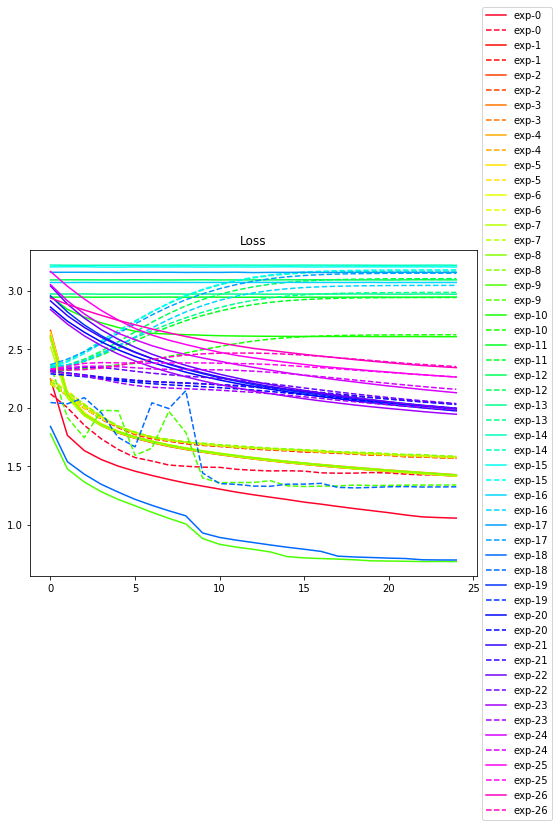

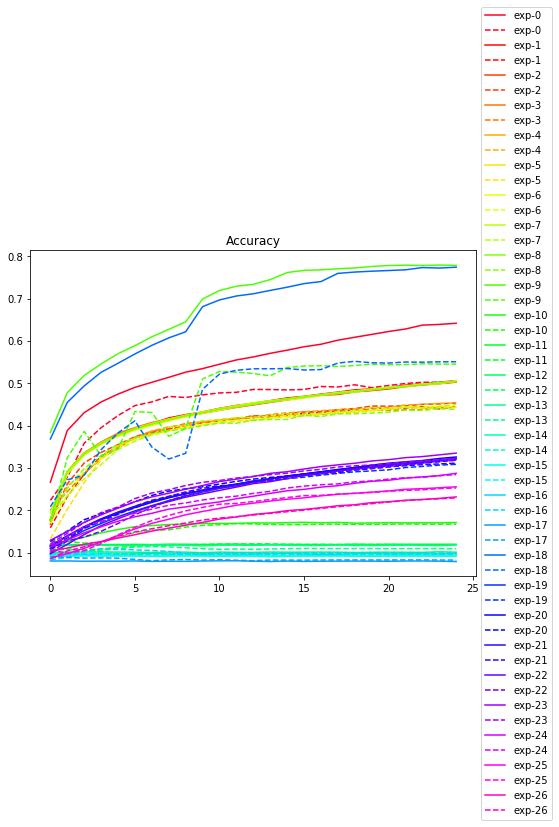

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()